In [1]:
from pyannote.audio.pipelines import SpeakerDiarization
from pyannote.audio import Model, Pipeline
from huggingface_hub import login
from IPython.display import Audio
from transformers import WhisperProcessor, WhisperForConditionalGeneration, pipeline
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
import numpy as np
import pandas as pd
import soundfile as sf
import re
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

# Suppress PyTorch warnings
torch.set_printoptions(profile="default")


INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
C:\Users\harsh\anaconda3\Lib\inspect.py:1001: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if ismodule(module) and hasattr(module, '__file__'):


In [2]:
audio_path = r"C:\Users\harsh\OneDrive\Desktop\Audio Analyzer\convo_audio_analyzer_env\data\pharmacy audio.mp3" # give your audio file path here

In [3]:
# Load Whisper model for transcription
model_name = "openai/whisper-large-v3-turbo"
processor = WhisperProcessor.from_pretrained(model_name)
model = WhisperForConditionalGeneration.from_pretrained(model_name)

In [4]:
# Authenticate with Hugging Face API
HUGGINGFACE_TOKEN = " "  # Replace with your token
login(HUGGINGFACE_TOKEN)

In [5]:
# # Load the diarization model using the API token
# diarization_pipeline = SpeakerDiarization.from_pretrained(
#     "pyannote/speaker-diarization-3.1",
#     use_auth_token=HUGGINGFACE_TOKEN
# )

# Instantiate the pipeline
diarization_pipeline = Pipeline.from_pretrained(
    "G-Root/speaker-diarization-optimized",
    use_auth_token=""
)

In [6]:
def audio_preprocessing(audio_file):
    y, sr = librosa.load(audio_file, sr=16000)  # Resample to 16kHz
    # Trim silence
    y_trimmed, _ = librosa.effects.trim(y)
    # Normalize volume
    y_normalized = librosa.util.normalize(y_trimmed)
    return y_normalized, sr

In [7]:
audio_input, sr = audio_preprocessing(audio_path)
Audio(audio_input, rate = 16000)

In [8]:
def diarize_audio(audio_path):
    """Perform speaker diarization and return timestamps with speaker labels."""
    diarization = diarization_pipeline(audio_path)
    speaker_segments = []

    for turn, _, speaker in diarization.itertracks(yield_label=True):
        speaker_segments.append((turn.start, turn.end, speaker))
     
    return speaker_segments  # Returns a list of (start_time, end_time, speaker)


In [9]:
import librosa
import torch

def transcribe_audio_segment(audio_path, start_time, end_time, sr=16000):
    """Extract and transcribe a specific speaker segment from audio, ensuring output is in English."""
    
    # Load the full audio file
    y, sr = audio_preprocessing(audio_path)

    # Extract the specific speaker segment
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    segment = y[start_sample:end_sample]

    # Convert to tensor for Whisper transcription
    input_features = processor(segment, sampling_rate=16000, return_tensors="pt").input_features
    attention_mask = torch.ones_like(input_features)

    # Transcribe using Whisper, forcing English output
    with torch.no_grad():
        predicted_ids = model.generate(
            input_features,
            attention_mask=attention_mask,
            forced_decoder_ids=processor.get_decoder_prompt_ids(language="en")  # Ensures output is in English
        )

    transcription = processor.decode(predicted_ids[0], skip_special_tokens=True)

    return transcription  # Returns the text spoken in the segment


In [10]:
def diarization_and_transcription(audio_path):
    """Perform both speaker diarization and transcription."""
    speaker_segments = diarize_audio(audio_path)  # Get speaker timestamps
    transcript_with_speakers = []

    for start, end, speaker in speaker_segments:
        text = transcribe_audio_segment(audio_path, start, end)
        transcript_with_speakers.append(f"{speaker} [{start:.2f}s - {end:.2f}s]: {text}")

    return "\n".join(transcript_with_speakers)


In [11]:
# Run the diarization & transcription process
final_transcript = diarization_and_transcription(audio_path)

In [12]:
# Extract structured data from transcript
data = []
for line in final_transcript.strip().split("\n"):
    match = re.match(r"(SPEAKER_\d+) \[(\d+\.\d+s - \d+\.\d+s)\]: (.+)", line)
    if match:
        speaker, timestamp, text = match.groups()
        data.append([speaker, timestamp, text])

# Create DataFrame
df = pd.DataFrame(data, columns=["Speaker", "Timestamp", "Text"])

# Mapping Speaker Names
speaker_mapping = {
    "SPEAKER_00": "Customer",
    "SPEAKER_01": "Representative"
}

# Apply Mapping
df["Speaker"] = df["Speaker"].map(speaker_mapping)

# Display DataFrame
df.head(25)

Speaker          Timestamp  \
0   Representative      0.60s - 3.39s   
1         Customer     4.52s - 12.20s   
2         Customer    12.38s - 16.30s   
3   Representative    17.55s - 21.34s   
4         Customer    22.49s - 27.32s   
5   Representative    28.99s - 29.83s   
6   Representative    29.97s - 31.35s   
7   Representative    31.94s - 32.68s   
8   Representative    36.11s - 39.77s   
9         Customer    40.80s - 43.26s   
10  Representative    44.73s - 50.25s   
11        Customer    51.63s - 55.13s   
12  Representative    56.58s - 62.47s   
13  Representative    63.21s - 65.03s   
14  Representative    71.29s - 72.31s   
15  Representative    76.49s - 76.76s   
16  Representative    77.07s - 82.03s   
17  Representative    82.08s - 83.53s   
18        Customer    85.52s - 90.03s   
19  Representative    92.61s - 93.70s   
20  Representative    94.28s - 99.96s   
21  Representative  100.45s - 105.50s   
22        Customer  107.02s - 110.53s   
23  Representative  111.95s - 115.83s   
24        Customer  116.97s - 117.77s   

                                                 Text  
0    I think if we're calling contest a pharmacy, ...  
1    I'm going to be back in a few weeks after noo...  
2    I've already my situation, but it's been week...  
3    I'm trying to change the frustration. Can you...  
4    I'm trying to refill of my prescription drug ...  
5                                          I'm sorry.  
6             I'm really happy to check that for you.  
7                           I'll be back in a minute.  
8    I see here that you are on a generic form of ...  
9    I guess I was taking a generic form of a foot...  
10   Okay, so I see that your doctor stopped descr...  
11   I really bet doesn't sound right. I don't rem...  
12   Yeah, be happy to check that for you. Sometim...  
13                           Let me take a look here.  
14                                        The moment.  
15                     I'm going to be back with you.  
16   So I'm seeing here that your doctor had these...  
17                                              2221.  
18   I'm definitely supposed to be taking somethin...  
19                                         I'm sorry.  
20   Yeah, according to the latest records provide...  
21   Would you like us to go ahead and fill that p...  
22   Yeah, thank you so much. I'm almost out to th...  
23   You're very welcome Mary and I'll please let ...  
24                                         Thank you.

In [13]:
print(final_transcript)

SPEAKER_01 [0.60s - 3.39s]:  I think if we're calling contest a pharmacy, who am I speaking with today?
SPEAKER_00 [4.52s - 12.20s]:  I'm going to be back in a few weeks after noon. I'm going to get a hold of someone for a week and tell that I would get a call back.
SPEAKER_00 [12.38s - 16.30s]:  I've already my situation, but it's been weeks and no one's contacting me, so I thought I'd call.
SPEAKER_01 [17.55s - 21.34s]:  I'm trying to change the frustration. Can you tell me what exactly you're trying to accomplish?
SPEAKER_00 [22.49s - 27.32s]:  I'm trying to refill of my prescription drug so that my doctor prescribes to be for cholesterol.
SPEAKER_01 [28.99s - 29.83s]:  I'm sorry.
SPEAKER_01 [29.97s - 31.35s]:  I'm really happy to check that for you.
SPEAKER_01 [31.94s - 32.68s]:  I'll be back in a minute.
SPEAKER_01 [36.11s - 39.77s]:  I see here that you are on a generic form of lipitores that right?
SPEAKER_00 [40.80s - 43.26s]:  I guess I was taking a generic form of a footwear.

## SENTIMENT ANALYSIS

In [14]:
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
# Apply sentiment analysis
df["Sentiment"] = df["Text"].apply(lambda x: sentiment_pipeline(x)[0]['label'])
df.head()

Speaker        Timestamp  \
0  Representative    0.60s - 3.39s   
1        Customer   4.52s - 12.20s   
2        Customer  12.38s - 16.30s   
3  Representative  17.55s - 21.34s   
4        Customer  22.49s - 27.32s   

                                                Text Sentiment  
0   Thank you for calling Contosa Pharmacy. Who a...  positive  
1   Good afternoon. My name is Mary. I'm calling ...   neutral  
2   regarding my situation, but it's been weeks a...  negative  
3   I understand your frustration, Mary. Can you ...   neutral  
4   I'm trying to get a refill of my prescription...   neutral

In [16]:
print(df)

           Speaker          Timestamp  \
0   Representative      0.60s - 3.39s   
1         Customer     4.52s - 12.20s   
2         Customer    12.38s - 16.30s   
3   Representative    17.55s - 21.34s   
4         Customer    22.49s - 27.32s   
5   Representative    28.99s - 29.83s   
6   Representative    29.97s - 31.35s   
7   Representative    31.94s - 32.68s   
8   Representative    36.11s - 39.77s   
9         Customer    40.80s - 43.26s   
10  Representative    44.73s - 50.25s   
11        Customer    51.63s - 55.13s   
12  Representative    56.58s - 62.47s   
13  Representative    63.21s - 65.03s   
14  Representative    71.29s - 72.31s   
15  Representative    76.49s - 76.76s   
16  Representative    77.07s - 82.03s   
17  Representative    82.08s - 83.53s   
18        Customer    85.52s - 90.03s   
19  Representative    92.61s - 93.70s   
20  Representative    94.28s - 99.96s   
21  Representative  100.45s - 105.50s   
22        Customer  107.02s - 110.53s   
23  Representati

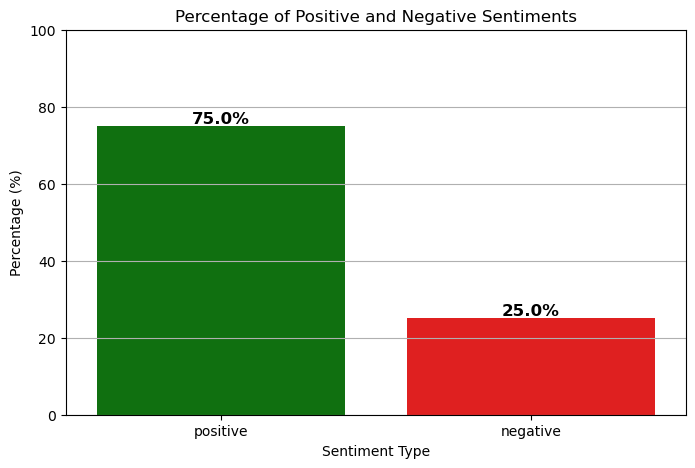

In [17]:
# Count occurrences of each sentiment category
sentiment_counts = df["Sentiment"].value_counts()

# Ensure "positive" and "negative" exist; otherwise, set them to 0
sentiment_counts = sentiment_counts.reindex(["positive", "negative"], fill_value=0)

# Convert counts to percentages
total = sentiment_counts.sum()
sentiment_percentages = (sentiment_counts / total) * 100

# Plot a bar chart
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=sentiment_percentages.index, y=sentiment_percentages.values, palette={"positive": "green", "negative": "red"})

# Annotate bars with percentage values
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add labels and title
plt.xlabel("Sentiment Type")
plt.ylabel("Percentage (%)")
plt.title("Percentage of Positive and Negative Sentiments")
plt.ylim(0, 100)  # Ensure the y-axis goes up to 100%
plt.grid(axis="y")

# Show plot
plt.show()


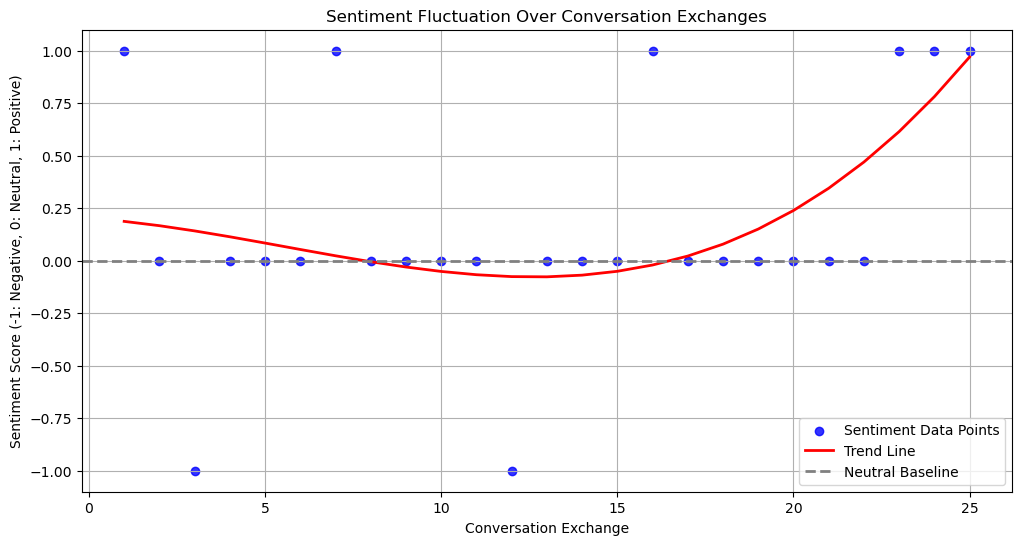

In [18]:
# Map sentiment to numerical values
sentiment_mapping = {
    "positive": 1,
    "neutral": 0,
    "negative": -1
}

df["Sentiment Score"] = df["Sentiment"].map(sentiment_mapping)

# Assign exchange numbers for X-axis
df["Exchange"] = range(1, len(df) + 1)

# Create figure
plt.figure(figsize=(12, 6))

# Scatter plot of sentiment points
plt.scatter(df["Exchange"], df["Sentiment Score"], color="blue", label="Sentiment Data Points", alpha=0.8)

# Fit trend line using polynomial regression
z = np.polyfit(df["Exchange"], df["Sentiment Score"], 3)  # Degree 3 polynomial
p = np.poly1d(z)
plt.plot(df["Exchange"], p(df["Exchange"]), "r-", label="Trend Line", linewidth=2)

# Add neutral baseline
plt.axhline(y=0, color="gray", linestyle="dashed", linewidth=2, label="Neutral Baseline")

# Customize plot
plt.xlabel("Conversation Exchange")
plt.ylabel("Sentiment Score (-1: Negative, 0: Neutral, 1: Positive)")
plt.title("Sentiment Fluctuation Over Conversation Exchanges")
plt.legend()
plt.grid()
plt.show()

### INTEND ANALYSIS

In [19]:

# Load Zero-Shot Classification Model
intent_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define Your 5 Custom Intent Labels
custom_labels = [
    "Informational Intent",
    "Transactional Intent",
    "Support or Troubleshooting Intent",
    "Complaint Intent",
    "Confirmation Intent",
    "Navigational Intent",
    "Acknowledgment Intent",
    "Closing Intent",
    "Assurance Intent",
    "Greeting Intent"
    ]

In [20]:
# Step 1: Classify Intent & Sentiment
def classify_intent(text):
    result = intent_classifier(text, custom_labels, multi_label=False)
    return result["labels"][0]

df["Intent"] = df["Text"].apply(classify_intent)

In [21]:
df[["Text", "Intent"]]

Text  \
0    Thank you for calling Contosa Pharmacy. Who a...   
1    Good afternoon. My name is Mary. I'm calling ...   
2    regarding my situation, but it's been weeks a...   
3    I understand your frustration, Mary. Can you ...   
4    I'm trying to get a refill of my prescription...   
5                                               Okay.   
6          I'm certainly happy to check that for you.   
7                                      moment please.   
8    I see here that you are on a generic form of ...   
9      Yes, I was taking the generic form of Lipitor.   
10   Okay, so I see that your doctor stopped descr...   
11   Really, that doesn't sound right. I don't rem...   
12   Yeah, I'd be happy to check that for you beca...   
13                        So let me take a look here.   
14                                     At the moment.   
15                                         Thank you.   
16   So I'm seeing here that your doctor had these...   
17                                      through 2021.   
18   Oh, I mean, I'm definitely supposed to be tak...   
19                                              Okay.   
20   Yeah, according to the latest records provide...   
21   Would you like us to go ahead and fill that p...   
22   Yeah, thank you so much. I'm almost out, so t...   
23   You're very welcome, Mary. Please let us know...   
24                                         Thank you.   

                               Intent  
0               Acknowledgment Intent  
1                     Greeting Intent  
2   Support or Troubleshooting Intent  
3               Acknowledgment Intent  
4   Support or Troubleshooting Intent  
5                 Confirmation Intent  
6   Support or Troubleshooting Intent  
7                 Confirmation Intent  
8               Acknowledgment Intent  
9               Acknowledgment Intent  
10                Confirmation Intent  
11  Support or Troubleshooting Intent  
12  Support or Troubleshooting Intent  
13              Acknowledgment Intent  
14              Acknowledgment Intent  
15              Acknowledgment Intent  
16                Confirmation Intent  
17              Acknowledgment Intent  
18              Acknowledgment Intent  
19                Confirmation Intent  
20              Acknowledgment Intent  
21                Confirmation Intent  
22              Acknowledgment Intent  
23              Acknowledgment Intent  
24              Acknowledgment Intent

In [22]:
# Count occurrences of each intent
intent_counts = Counter(df["Intent"])

# Convert to DataFrame for plotting
intent_df = pd.DataFrame(intent_counts.items(), columns=["Intent", "Count"])

# Plot intent distribution
sns.barplot(x="Intent", y="Count", data=intent_df)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Intent")
plt.ylabel("Count")
plt.title("Intent Distribution")
plt.show()

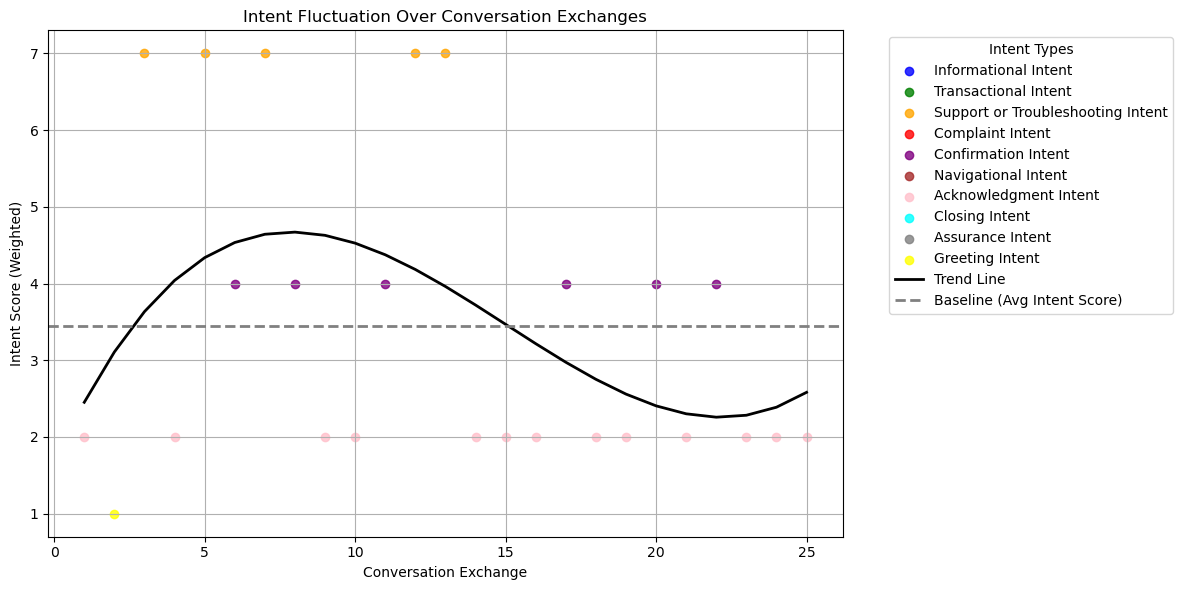

In [23]:
# Define intent weight mappings
intent_weights = {
    "Informational Intent": 5,
    "Transactional Intent": 6,
    "Support or Troubleshooting Intent": 7,
    "Complaint Intent": 8,
    "Confirmation Intent": 4,
    "Navigational Intent": 3,
    "Acknowledgment Intent": 2,
    "Closing Intent": 1,
    "Assurance Intent": 4,
    "Greeting Intent": 1
}

# Assign unique colors to each intent
intent_colors = {
    "Informational Intent": "blue",
    "Transactional Intent": "green",
    "Support or Troubleshooting Intent": "orange",
    "Complaint Intent": "red",
    "Confirmation Intent": "purple",
    "Navigational Intent": "brown",
    "Acknowledgment Intent": "pink",
    "Closing Intent": "cyan",
    "Assurance Intent": "gray",
    "Greeting Intent": "yellow"
}

# Convert Intent column to numerical weight values
df["Intent Score"] = df["Intent"].map(intent_weights)

# Assign sequential exchange numbers for X-axis
df["Exchange"] = range(1, len(df) + 1)

# Create figure
plt.figure(figsize=(12, 6))

# Plot each intent as a scatter point with its assigned color
for intent, color in intent_colors.items():
    subset = df[df["Intent"] == intent]
    plt.scatter(subset["Exchange"], subset["Intent Score"], color=color, label=intent, alpha=0.8)


# Fit a smooth trend line using polynomial regression
z = np.polyfit(df["Exchange"], df["Intent Score"], 3)  # Degree 3 polynomial
p = np.poly1d(z)
plt.plot(df["Exchange"], p(df["Exchange"]), "k-", label="Trend Line", linewidth=2)  # Black line for trend

# Calculate the baseline (e.g., average intent score)
baseline_value = df["Intent Score"].mean()

# Add horizontal baseline
plt.axhline(y=baseline_value, color="gray", linestyle="dashed", linewidth=2, label="Baseline (Avg Intent Score)")

# Customize plot
plt.xlabel("Conversation Exchange")
plt.ylabel("Intent Score (Weighted)")
plt.title("Intent Fluctuation Over Conversation Exchanges")
plt.legend(title="Intent Types", bbox_to_anchor=(1.05, 1), loc="upper left")  # Intent legend outside the plot
plt.grid()
plt.tight_layout()

# Show graph
plt.show()



### KEYWORD EXTRACTION